# Build a model to decode sequences of digits from images

In [29]:
%matplotlib inline

# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from tensorflow.models.rnn import rnn_cell
from tensorflow.models.rnn import rnn
from six.moves import cPickle as pickle
from six.moves import range
import sys
import matplotlib.pyplot as plt

## Load data

In [30]:
np.random.seed(133)

def load_data(file_name,valid_size=0):
     with open(file_name, 'r') as f:
        data=pickle.load(f)
        labels=data["label"]
        images=data["image"]
        if valid_size:
            all_data=zip(images,labels)
            np.random.shuffle(all_data)
            valid_data=all_data[:valid_size]
            valid_images,valid_labels=tuple([list(l) for l in zip(*valid_data)])
            train_data=all_data[valid_size:]
            train_images,train_labels=tuple([list(l) for l in zip(*train_data)])
            return train_images,train_labels,valid_images,valid_labels
        return images,labels
valid_size=1670 #about 5% of the data
loaded_train_data,loaded_train_labels,loaded_valid_data,loaded_valid_labels=load_data("train.pickle",valid_size)
loaded_test_data,loaded_test_labels=load_data("test.pickle")
print("train:",len(loaded_train_data),len(loaded_train_labels))
print("validation:",len(loaded_valid_data),len(loaded_valid_labels))
print("test:",len(loaded_test_data),len(loaded_test_labels))

train: 31732 31732
validation: 1670 1670
test: 13068 13068


### Preprocess data

In [31]:
max_labels=6
num_labels=11
distinct_labels=np.arange(num_labels).astype(np.float32) 
blanc_label=distinct_labels[0] # 0 represensts blanc label
image_size=32

def pad_label(image_labels):
    """pad the labels of one image with blanc label"""  
    if len(image_labels) > max_labels:
        raise Exception("found image with more labels than max label "+str(len(image_labels)))
    if len(image_labels) == 0:
        raise Exception("found image with 0 labels"+str(len(image_labels)))
    expanded_labels=list()
    for image_label in image_labels:
        expanded_labels.append(image_label)
    while len(expanded_labels) < max_labels:
        expanded_labels.append(blanc_label)
    return expanded_labels
    
def pad_labels(labels):
    """pad the labels of dataset with blanc label"""
    return [pad_label(label) for label in labels]

def to_one_hot(labels):
    """convert labels to 1-hot encoding"""
    return (distinct_labels == labels[:,:,None]).astype(np.float32)

def from_one_hot(labels):
    """retrieve labels from 1-hot encoded"""
    return np.argmax(labels,2)

def preprocess_labels(labels):
    """padd labels, and then convert them to 1-hot"""
    padded_labels=pad_labels(labels)
    np_labels=np.asanyarray(padded_labels,dtype=np.float32)
    one_hot=to_one_hot(np_labels)
    return one_hot

def rgb2gray(rgb):
    """convert rgb image to gray
        see http://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python"""
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def preprocess_images(images):
    """convert to numpy array and apply grayscale"""
    np_images=np.asanyarray(images,dtype=np.float32)
    gray_images=rgb2gray(np_images)
    reshaped_images=gray_images.reshape((-1, image_size * image_size)).astype(np.float32)
    return reshaped_images
    
def preprocess_data(images,labels):
    return preprocess_images(images),preprocess_labels(labels)
 

In [32]:
train_data,train_labels=preprocess_data(loaded_train_data,loaded_train_labels)
valid_data,valid_labels=preprocess_data(loaded_valid_data,loaded_valid_labels)
test_data,test_labels=preprocess_data(loaded_test_data,loaded_test_labels)

#### Display some labels and images to make sure that preprocessing ran fine

showing some labels and images for train
shape:  (31732, 1024) (31732, 6, 11)
[[7 3 0 0 0 0]]


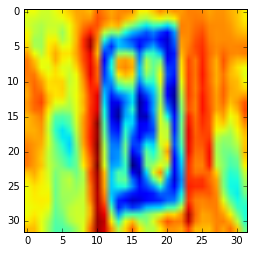

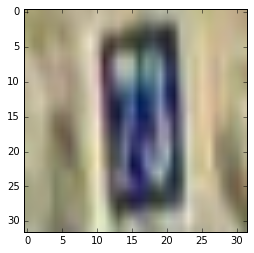

[[2 5 0 0 0 0]]


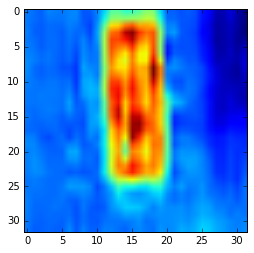

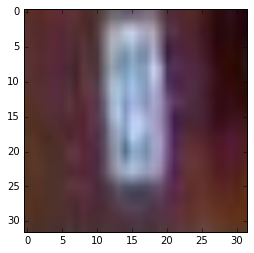

[[1 4 1 0 0 0]]


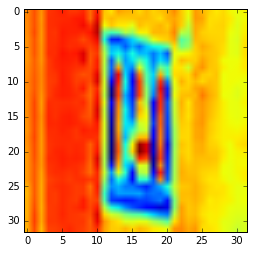

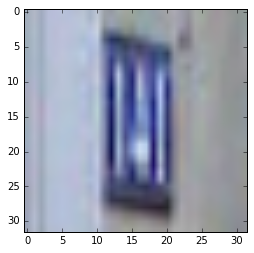

[[5 1 0 0 0 0]]


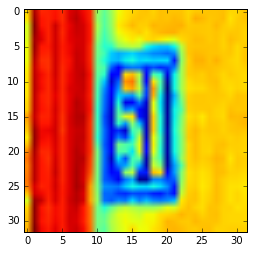

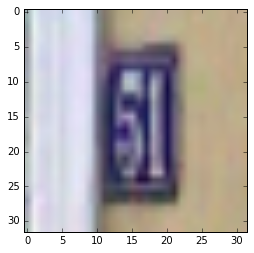

[[6 4 0 0 0 0]]


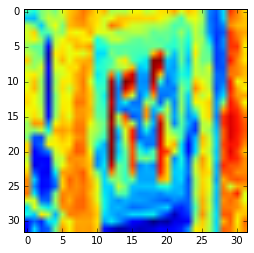

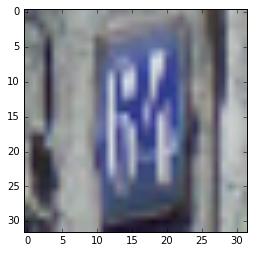

showing some labels and images for valid
shape:  (1670, 1024) (1670, 6, 11)
[[ 2 10  0  0  0  0]]


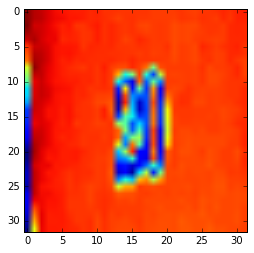

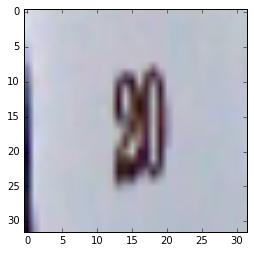

[[9 9 0 0 0 0]]


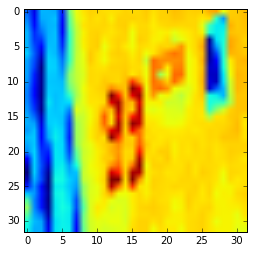

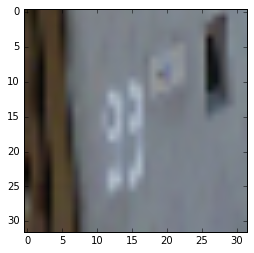

[[9 9 0 0 0 0]]


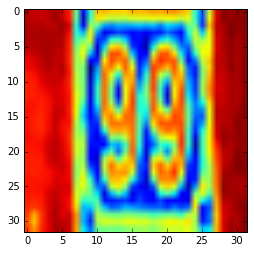

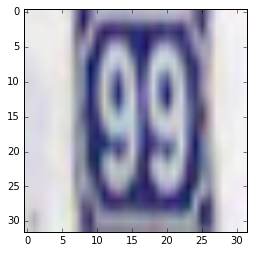

[[1 4 0 0 0 0]]


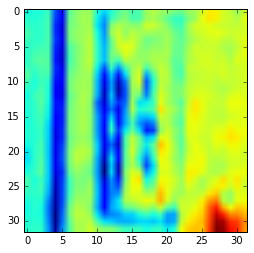

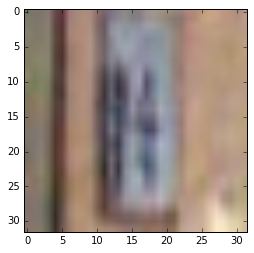

[[1 3 6 0 0 0]]


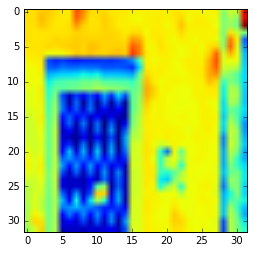

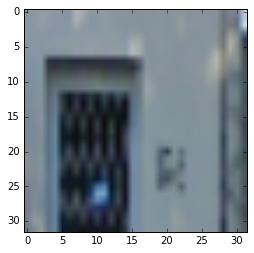

showing some labels and images for test
shape:  (13068, 1024) (13068, 6, 11)
[[1 4 0 0 0 0]]


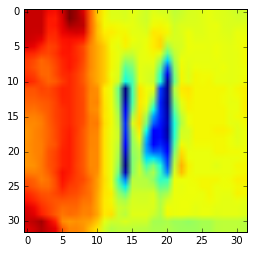

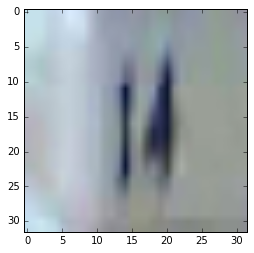

[[7 8 0 0 0 0]]


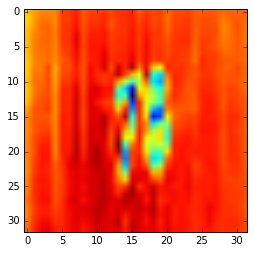

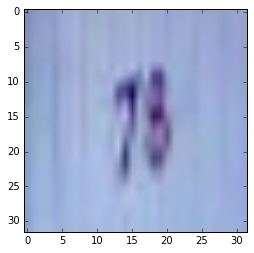

[[5 0 0 0 0 0]]


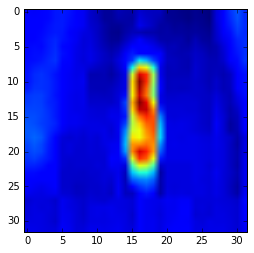

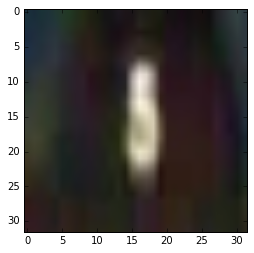

[[1 6 0 0 0 0]]


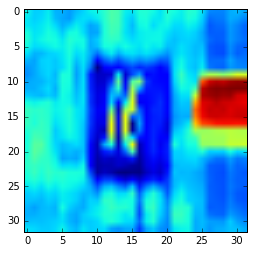

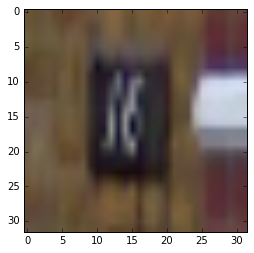

[[1 1 7 0 0 0]]


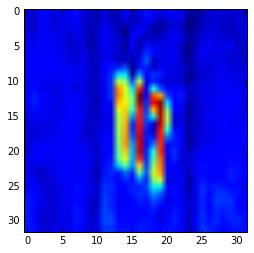

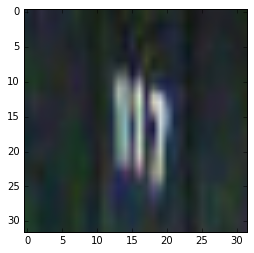

In [33]:
def display_image(image):
    plt.figure()
    plt.imshow(image)
    plt.show()
    
def display_images(data,labels,loaded_data,name=None,num_images=5):
    print ("showing some labels and images for %s"%name)  
    print ("shape: ",data.shape,labels.shape)
    total_images=data.shape[0]
    for i in np.random.choice(total_images,num_images):
            print(from_one_hot(labels[[i]]))
            display_image(data[i].reshape(image_size,image_size))
            display_image(loaded_data[i])

display_images(train_data,train_labels,loaded_train_data,"train")
display_images(valid_data,valid_labels,loaded_valid_data,"valid")
display_images(test_data,test_labels,loaded_test_data,"test")

In [34]:
class IndexGenerator(object):
    """generates the next index of the data from wich we can take a subset of length batch_size"""
    def __init__(self, length, batch_size):
        self._step=0
        self._length=length
        self._batch_size=batch_size
    def _next(self):
        offset = (self._step * self._batch_size) % (self._length - self._batch_size)
        self._step=self._step+1
        return offset
        
train_batch_size=64
valid_batch_size=64
test_batch_size=64
train_index_generator=IndexGenerator(len(train_data),train_batch_size)
valid_index_generator=IndexGenerator(len(valid_data),valid_batch_size)
test_index_generator=IndexGenerator(len(test_data),test_batch_size)
#print("train indexes:",train_index_generator._next(),train_index_generator._next(),train_index_generator._next(),train_index_generator._next())
#for i in range(100):
#    print(valid_index_generator._next())

## Build the graph

In [48]:
squared_image_size=image_size*image_size
rnn_num_hidden=squared_image_size
graph = tf.Graph()
with graph.as_default():   
   
    #data
    tf_data = tf.placeholder(tf.float32, [None, squared_image_size])
    tf_labels = tf.placeholder(tf.float32, [None, max_labels, num_labels])
    
    #rnn computation (see https://danijar.com/variable-sequence-lengths-in-tensorflow/)
    
    # repeat the images for dynamic rnn
    repeated_data=tf.tile(tf_data,[1,max_labels])
    rnn_data=tf.reshape(repeated_data,[-1,max_labels,squared_image_size])
    
    # Sequence length
    rnn_length=tf.fill(tf.slice(tf.shape(rnn_data),[0],[1]),max_labels)
    
    #dynamic rnn
    output, _ = rnn.dynamic_rnn(
        rnn_cell.GRUCell(rnn_num_hidden),
        rnn_data,
        dtype=tf.float32,
        sequence_length=rnn_length)
    
            
    # Classifier weights and biases.
    weights = tf.Variable(tf.truncated_normal([rnn_num_hidden, num_labels], stddev=0.1))
    biases = tf.Variable(tf.ones([num_labels]))
    
    #prediction
    output = tf.reshape(output, [-1, rnn_num_hidden])
    prediction = tf.nn.softmax(tf.matmul(output, weights) + biases)
    prediction = tf.reshape(prediction, [-1, max_labels, num_labels])
    
    #mask to avoid taking blank labels into account in loss and precision
    mask = tf.sign(tf.arg_max(tf_labels,2))
    mask=tf.cast(mask,tf.float32)    
    
    #length vector
    length = tf.reduce_sum(mask, reduction_indices=1)
    count=tf.reduce_sum(length)#number of non null labels
    
    
    
    # loss
    cross_entropy = tf_labels * tf.log(prediction)
    cross_entropy = -tf.reduce_sum(cross_entropy, reduction_indices=2)    
    cross_entropy *= mask
    cross_entropy = tf.reduce_sum(cross_entropy, reduction_indices=1)
    loss=tf.reduce_sum(cross_entropy)/count
    
    # optimizer
    learning_rate = 0.0003
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
    # accuracy
    hundred=tf.constant(100.0,tf.float32)
    correct = tf.equal(
        tf.argmax(tf_labels, 2), tf.argmax(prediction, 2))
    correct = tf.cast(correct, tf.float32)
    masked_correct = correct* mask
    masked_sum = tf.reduce_sum(masked_correct, reduction_indices=1)
    accuracy = tf.reduce_sum(masked_sum)*hundred/count
    

Initialized
Loss at step 0: 5.816995
Training accuracy: 23.6%
Validation accuracy: 20.7%
Loss at step 10: 2.378662
Training accuracy: 16.1%
Validation accuracy: 21.8%
Loss at step 20: 2.366934
Training accuracy: 15.2%
Validation accuracy: 14.5%
Loss at step 30: 2.192717
Training accuracy: 22.7%
Validation accuracy: 12.7%
Loss at step 40: 2.267199
Training accuracy: 16.2%
Validation accuracy: 16.9%
Loss at step 50: 2.204956
Training accuracy: 15.5%
Validation accuracy: 19.6%
Loss at step 60: 2.220190
Training accuracy: 14.8%
Validation accuracy: 15.3%
Loss at step 70: 2.253005
Training accuracy: 17.5%
Validation accuracy: 14.7%
Loss at step 80: 2.241007
Training accuracy: 18.0%
Validation accuracy: 20.8%
Loss at step 90: 2.190286
Training accuracy: 24.4%
Validation accuracy: 19.2%
Loss at step 100: 2.211236
Training accuracy: 22.2%
Validation accuracy: 17.0%
Loss at step 110: 2.205587
Training accuracy: 16.2%
Validation accuracy: 20.1%
Loss at step 120: 2.259524
Training accuracy: 19.2%

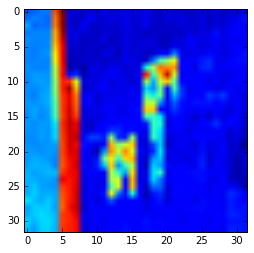

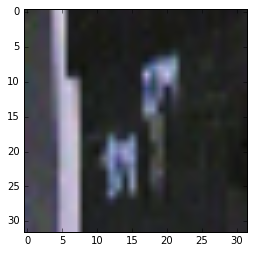

[[1 1 1 1 1 1]]


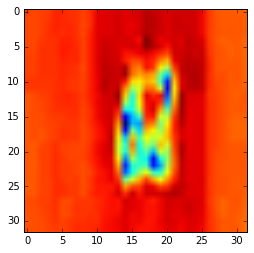

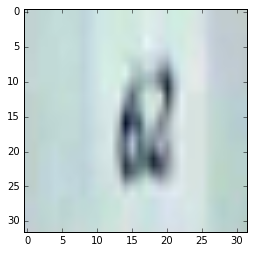

[[1 1 1 1 1 1]]


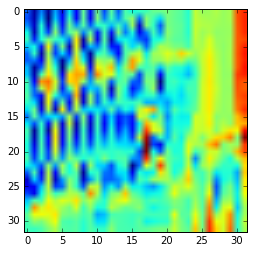

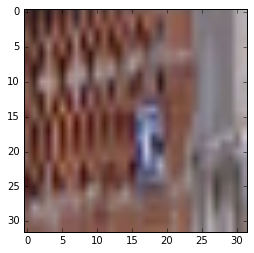

[[1 1 1 1 1 1]]


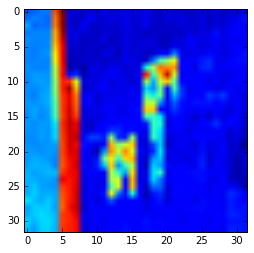

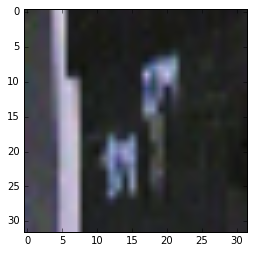

[[1 1 1 1 1 1]]


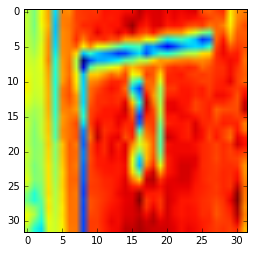

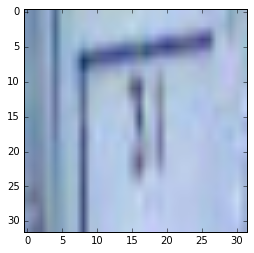

In [50]:
num_steps = 1000001

def feed_dict(offset,size,data,labels=None):
    dic={}
    dic[tf_data]=data[offset:offset+size]
    if labels!=None:
        dic[tf_labels]=labels[offset:offset+size]
    return dic

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    try:
        for step in range(num_steps):
            train_offset=train_index_generator._next()
            train_feed_dict=feed_dict(train_offset,train_batch_size,train_data,train_labels)
            session.run([optimizer],feed_dict=train_feed_dict)
            if (step % 10 == 0):
                train_loss,train_accuracy=session.run([loss,accuracy],feed_dict=train_feed_dict)
                print('Loss at step %d: %f' % (step, train_loss))
                print('Training accuracy: %.1f%%' % train_accuracy)
                
                valid_offset=valid_index_generator._next()
                valid_feed_dict=feed_dict(valid_offset,valid_batch_size,valid_data,valid_labels)
                print('Validation accuracy: %.1f%%' % accuracy.eval(feed_dict=valid_feed_dict))
    except KeyboardInterrupt:        
        test_offset = test_index_generator._next()
        test_feed_dict = feed_dict(test_offset,test_batch_size,test_data,test_labels)
        print('Test accuracy: %.1f%%' % accuracy.eval(feed_dict=test_feed_dict))
        test_prediction=prediction.eval(feed_dict=test_feed_dict)
        display_images(test_data[test_offset:test_offset+test_batch_size],test_prediction,
                      loaded_test_data[test_offset:test_offset+test_batch_size],"displaying predicted labels")

False

In [42]:
help(tf.abs)

Help on function abs in module tensorflow.python.ops.math_ops:

abs(x, name=None)
    Computes the absolute value of a tensor.
    
    Given a tensor of real numbers `x`, this operation returns a tensor
    containing the absolute value of each element in `x`. For example, if x is
    an input element and y is an output element, this operation computes
    \\(y = |x|\\).
    
    See [`tf.complex_abs()`](#tf_complex_abs) to compute the absolute value of a complex
    number.
    
    Args:
      x: A `Tensor` of type `float`, `double`, `int32`, or `int64`.
      name: A name for the operation (optional).
    
    Returns:
       A `Tensor` the same size and type as `x` with absolute values.



In [16]:
sess = tf.InteractiveSession()

# Some tensor we want to print the value of
a = tf.constant([1.0, 3.0])

# Add print operation
a = tf.Print(a, [a],message="printing a")

# Add more elements of the graph using a
b = tf.add(a, a).eval()
print(b)
print(a.eval())
sess.close()

[ 2.  6.]
[ 1.  3.]


In [52]:
help(tf)

Help on package tensorflow:

NAME
    tensorflow

FILE
    /usr/local/lib/python2.7/dist-packages/tensorflow/__init__.py

DESCRIPTION
    # Copyright 2015 Google Inc. All Rights Reserved.
    #
    # Licensed under the Apache License, Version 2.0 (the "License");
    # you may not use this file except in compliance with the License.
    # You may obtain a copy of the License at
    #
    #     http://www.apache.org/licenses/LICENSE-2.0
    #
    # Unless required by applicable law or agreed to in writing, software
    # distributed under the License is distributed on an "AS IS" BASIS,
    # WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
    # See the License for the specific language governing permissions and
    # limitations under the License.
    # ==============================================================================

PACKAGE CONTENTS
    contrib (package)
    core (package)
    examples (package)
    models (package)
    python (package)
    tenso